In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

plot_colors = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
sns.color_palette()

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

In [4]:
# Note to self: Remember to get data via API call
# Loading the data + a small clean up
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Forecasting/Energy Consumption/Data/ElectricityBalanceNonv.csv', sep=';', low_memory=False, decimal = ',')
df = df[df['PriceArea'] == 'DK1'] # DK1 is west of the great belt. DK2 is east of the great belt.
df = df[df['TotalLoad'].notna()] # Removing rows with NaN in TotalLoad. Basically the earliest years.
df = df.drop('HourUTC', axis='columns') # Keeping only danish timestamps
df = df.set_index('HourDK') # setting the hour as index
df.index = pd.to_datetime(df.index) # and converting it to datetime
df = df.sort_values('HourDK') # in case any hours are scrambled
df_total = df['TotalLoad']


In [5]:
df_total.head()

HourDK
2017-12-01 00:00:00    2048.199951
2017-12-01 01:00:00    1983.630005
2017-12-01 02:00:00    1950.300049
2017-12-01 03:00:00    1959.770020
2017-12-01 04:00:00    2017.469971
Name: TotalLoad, dtype: float64

<Axes: title={'center': 'Energy consumption west of the Great Belt (MWh)'}, xlabel='HourDK'>

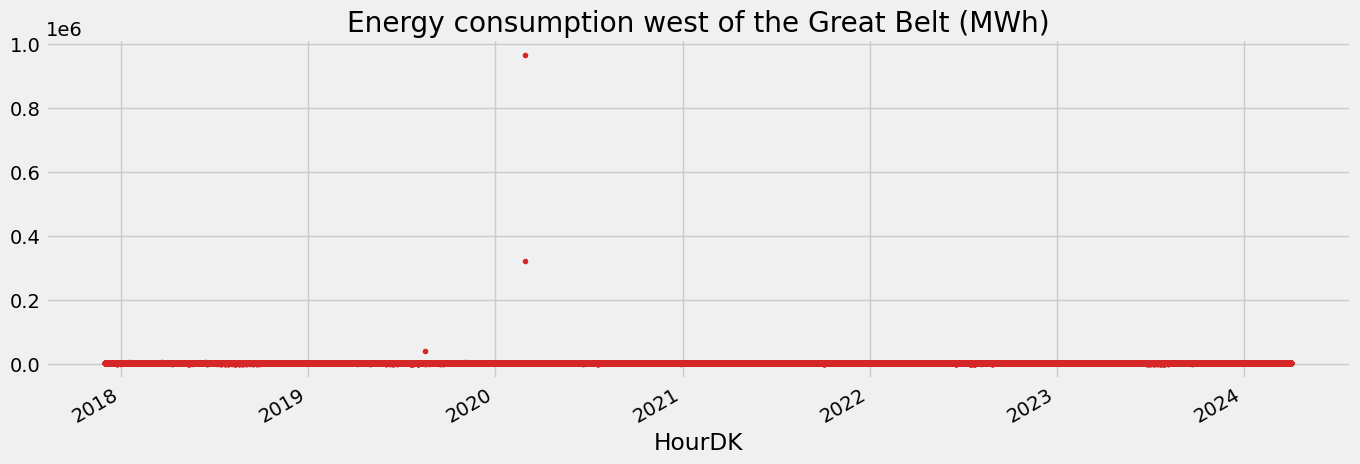

In [6]:
# Initial look at the data
df_total.plot(figsize=(15,5), color=plot_colors[3], title = 'Energy consumption west of the Great Belt (MWh)', style='.')

Some outlier detection is obviously needed

In [7]:
# Outlier detection is needed. Using LOF since the seasonality of the data has big swings.

# Reshape the data to 2D array
data = df_total.values.reshape(-1, 1)

# Initialize the LOF model
lof_model = LocalOutlierFactor(n_neighbors=24, contamination=0.0003)

# Fit the model
lof_model.fit(data)

# Predict outliers
outlier_predictions = lof_model.fit_predict(data)

# Get the indices of outliers
outlier_indices = df_total.index[outlier_predictions == -1]

# Print indices of detected outliers
print("Indices of detected outliers:", outlier_indices)


Indices of detected outliers: DatetimeIndex(['2018-01-17 09:00:00', '2018-03-22 09:00:00',
               '2018-06-14 16:00:00', '2019-05-01 17:00:00',
               '2019-05-01 18:00:00', '2019-08-16 10:00:00',
               '2019-11-04 08:00:00', '2020-02-27 14:00:00',
               '2020-02-28 07:00:00', '2021-02-08 17:00:00',
               '2021-02-15 10:00:00', '2021-10-03 02:00:00',
               '2021-10-03 03:00:00', '2021-10-03 04:00:00',
               '2021-10-03 05:00:00', '2021-10-03 06:00:00',
               '2021-10-26 13:00:00'],
              dtype='datetime64[ns]', name='HourDK', freq=None)


In [ ]:
def smooth_n_outliers(indice_list):
  for idx in indice_list:
      # Find the index of the current outlier
      idx_loc = df_total.index.get_loc(idx)
      # Calculate the average from the two values before and after the outlier index
      avg_value = (df_total.iloc[idx_loc - 2] + df_total.iloc[idx_loc - 1] + df_total.iloc[idx_loc + 1] + df_total.iloc[idx_loc + 2]) / 4
      # Replace the value of the current index with the average
      df_total.loc[idx] = avg_value

smooth_n_outliers(outlier_indices)

<Axes: title={'center': 'Energy consumption west of the Great Belt (MWh)'}, xlabel='HourDK'>

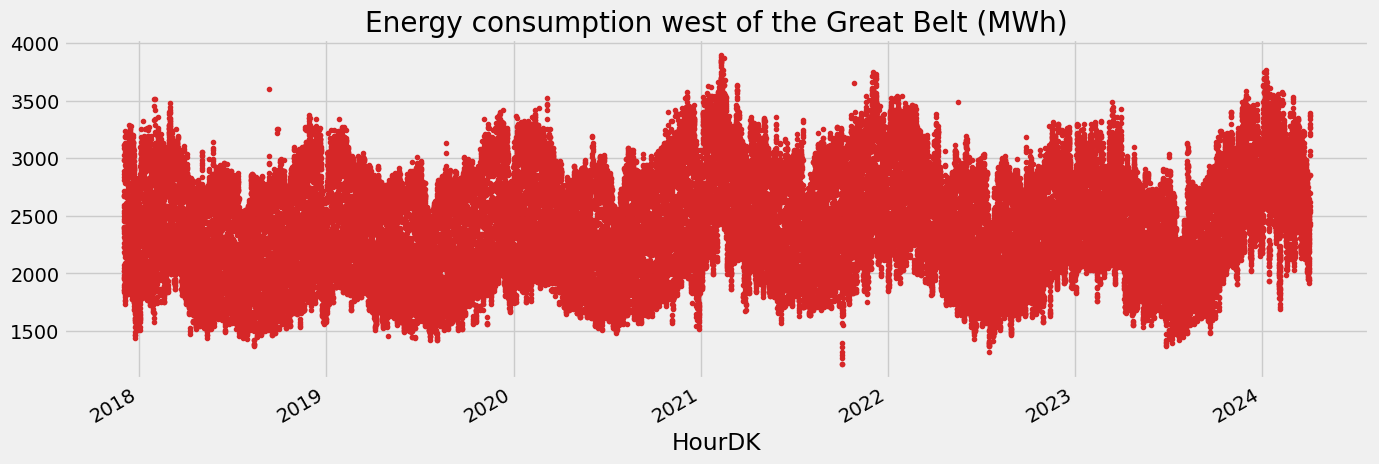

In [9]:
# Looking at the data after smoothing outliers
df_total.plot(figsize=(15,5), color=plot_colors[3], title = 'Energy consumption west of the Great Belt (MWh)', style='.')

<Axes: ylabel='Frequency'>

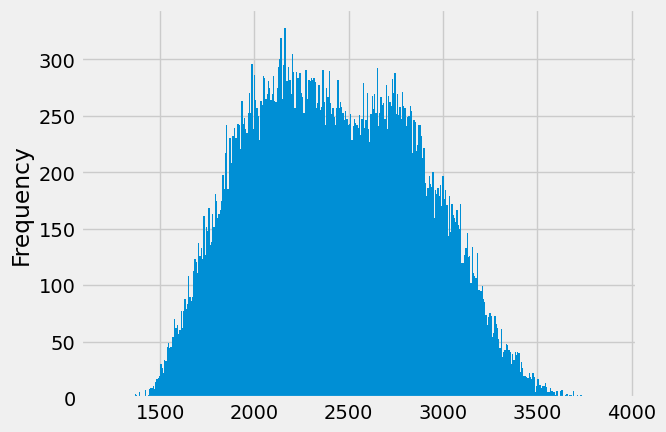

In [ ]:
# Checking if the data looks to be normally distributed
df['TotalLoad'].plot(kind='hist', bins=400)

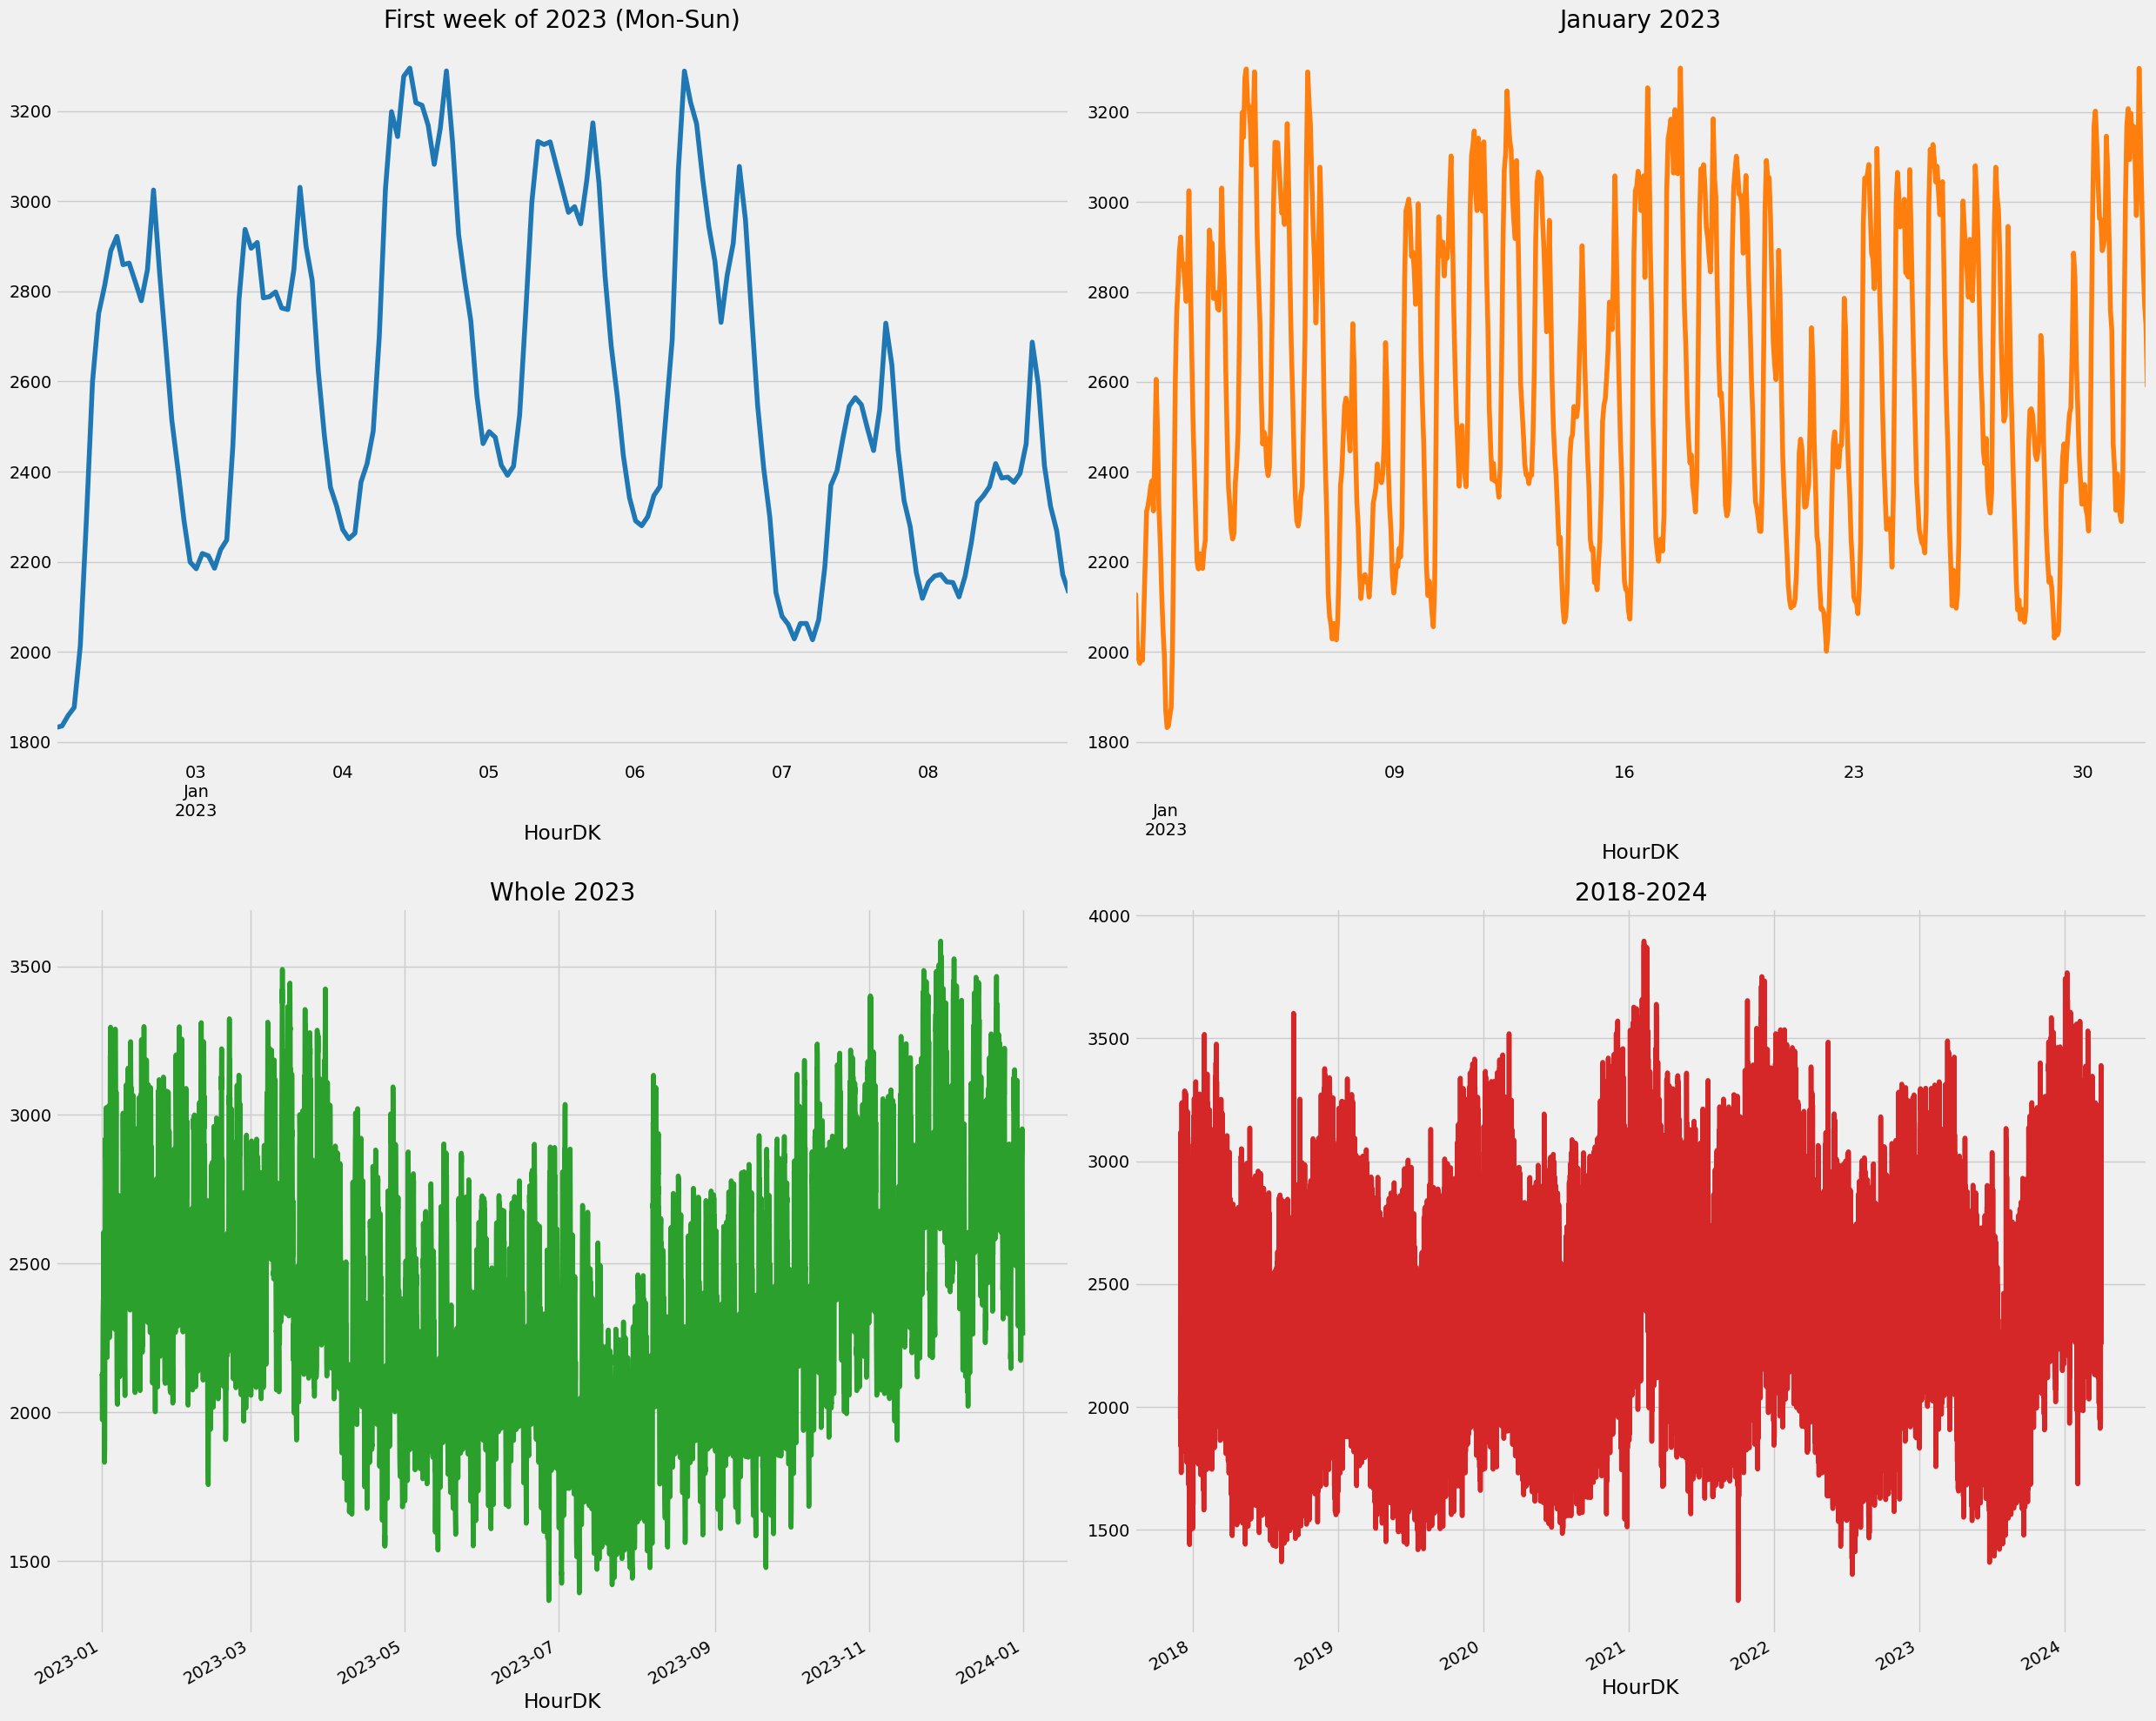

In [10]:
# Plotting seasonality and trends
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 20))

# Plot 1 – week
week = df_total.loc[('2023-01-02' < df_total.index) & ('2023-01-09' > df_total.index)]
week.plot(ax=axes[0,0], title='First week of 2023 (Mon-Sun)', color=plot_colors[0])

# Plot 2 – month
month = df_total.loc[('2023-01-01' < df_total.index) & ('2023-02-01' > df_total.index)]
month.plot(ax=axes[0,1], title='January 2023', color=plot_colors[1])

# Plot 3 – year
year = df_total.loc[('2023-01-01' < df_total.index) & ('2024-01-01' > df_total.index)]
year.plot(ax=axes[1,0], title='Whole 2023', color=plot_colors[2])

# Plot 4 - whole period
df_total.plot(ax=axes[1,1], title='2018-2024', color=plot_colors[3])

plt.tight_layout()
plt.show()


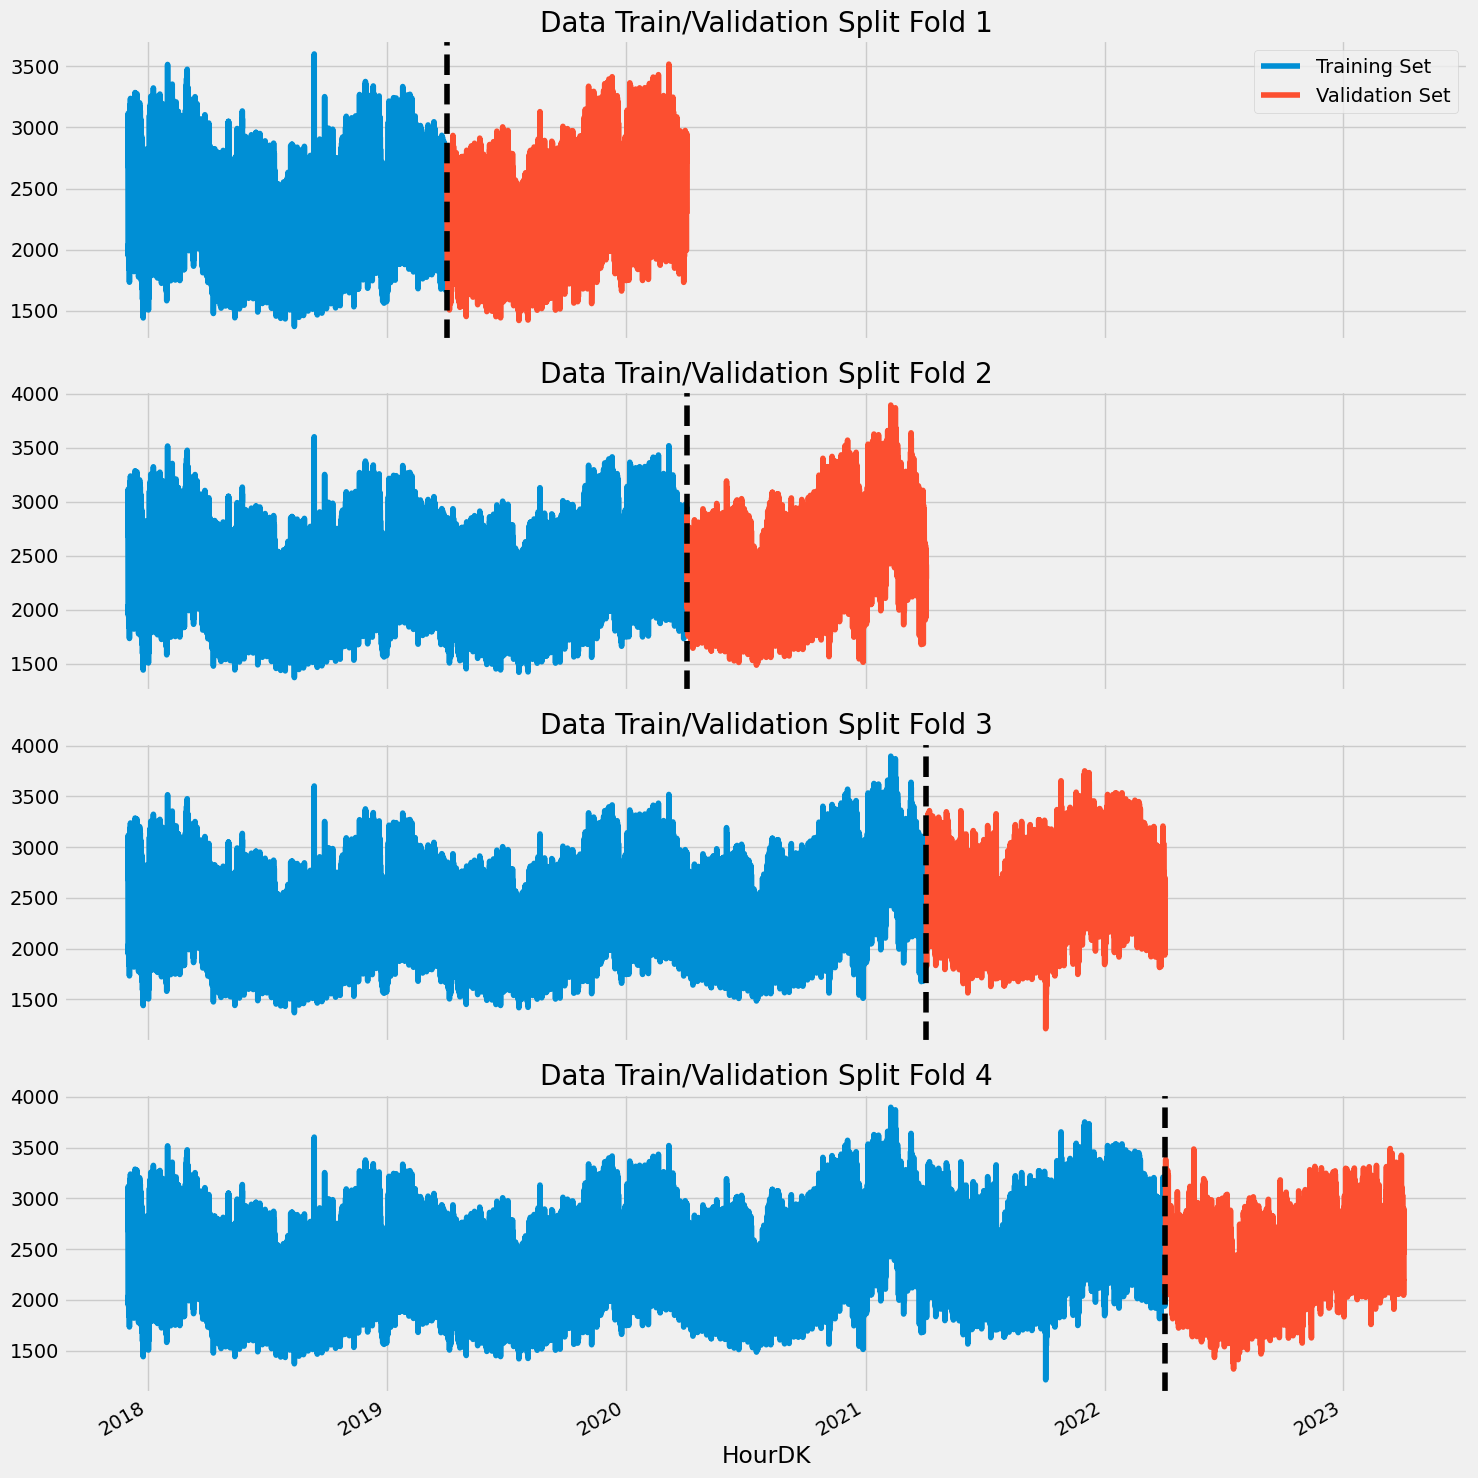

In [26]:
# Setting aside a final test set before making the timeseries k-fold split
train = df_total[:-24*365]
test = df_total[-24*365:] # Test set is 365 days, but from 01-01 to 31-12

# Visualizing the timeseries split
tss = TimeSeriesSplit(n_splits=4, test_size=24*365) # test size is a year. Taking yearly trends into account

fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train):
    train_viz = train.iloc[train_idx]
    test_viz = train.iloc[val_idx]
    train_viz.plot(ax=axs[fold],
                   label='Training Set',
                   title=f'Data Train/Validation Split Fold {fold+1}')
    test_viz.plot(ax=axs[fold],
                  label='Validation Set')
    axs[fold].axvline(test_viz.index.min(), color='black', ls='--')

    if fold == 0:  # Only create legend for the top subplot
        axs[fold].legend(['Training Set', 'Validation Set'], loc='upper right')

    fold += 1

plt.tight_layout()
plt.show()


In [27]:
# Feature engineering with time and lag
def create_time_features(df):
  # Basic time formats
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week

  # Adding lag features
  values = df['TotalLoad']
  values = pd.concat([values.shift(24*364), values.shift(24*7), values.shift(24)], axis=1) # 364 is essentially a year, but is divisble by 7, essentially making the lag the same day a year prior
  values.columns = ['lag_year', 'lag_week', 'lag_day']
  df = pd.concat([df, values], axis=1)

  return df

df_total = create_time_features(df_total.to_frame())
train = create_time_features(train.to_frame())
test = create_time_features(test.to_frame())

In [28]:
# Train set
X_train = train.iloc[: , 1:]
y_train = train.iloc[: , :1]

# Test set
X_test = test.iloc[: , 1:]
y_test = test.iloc[: , :1]

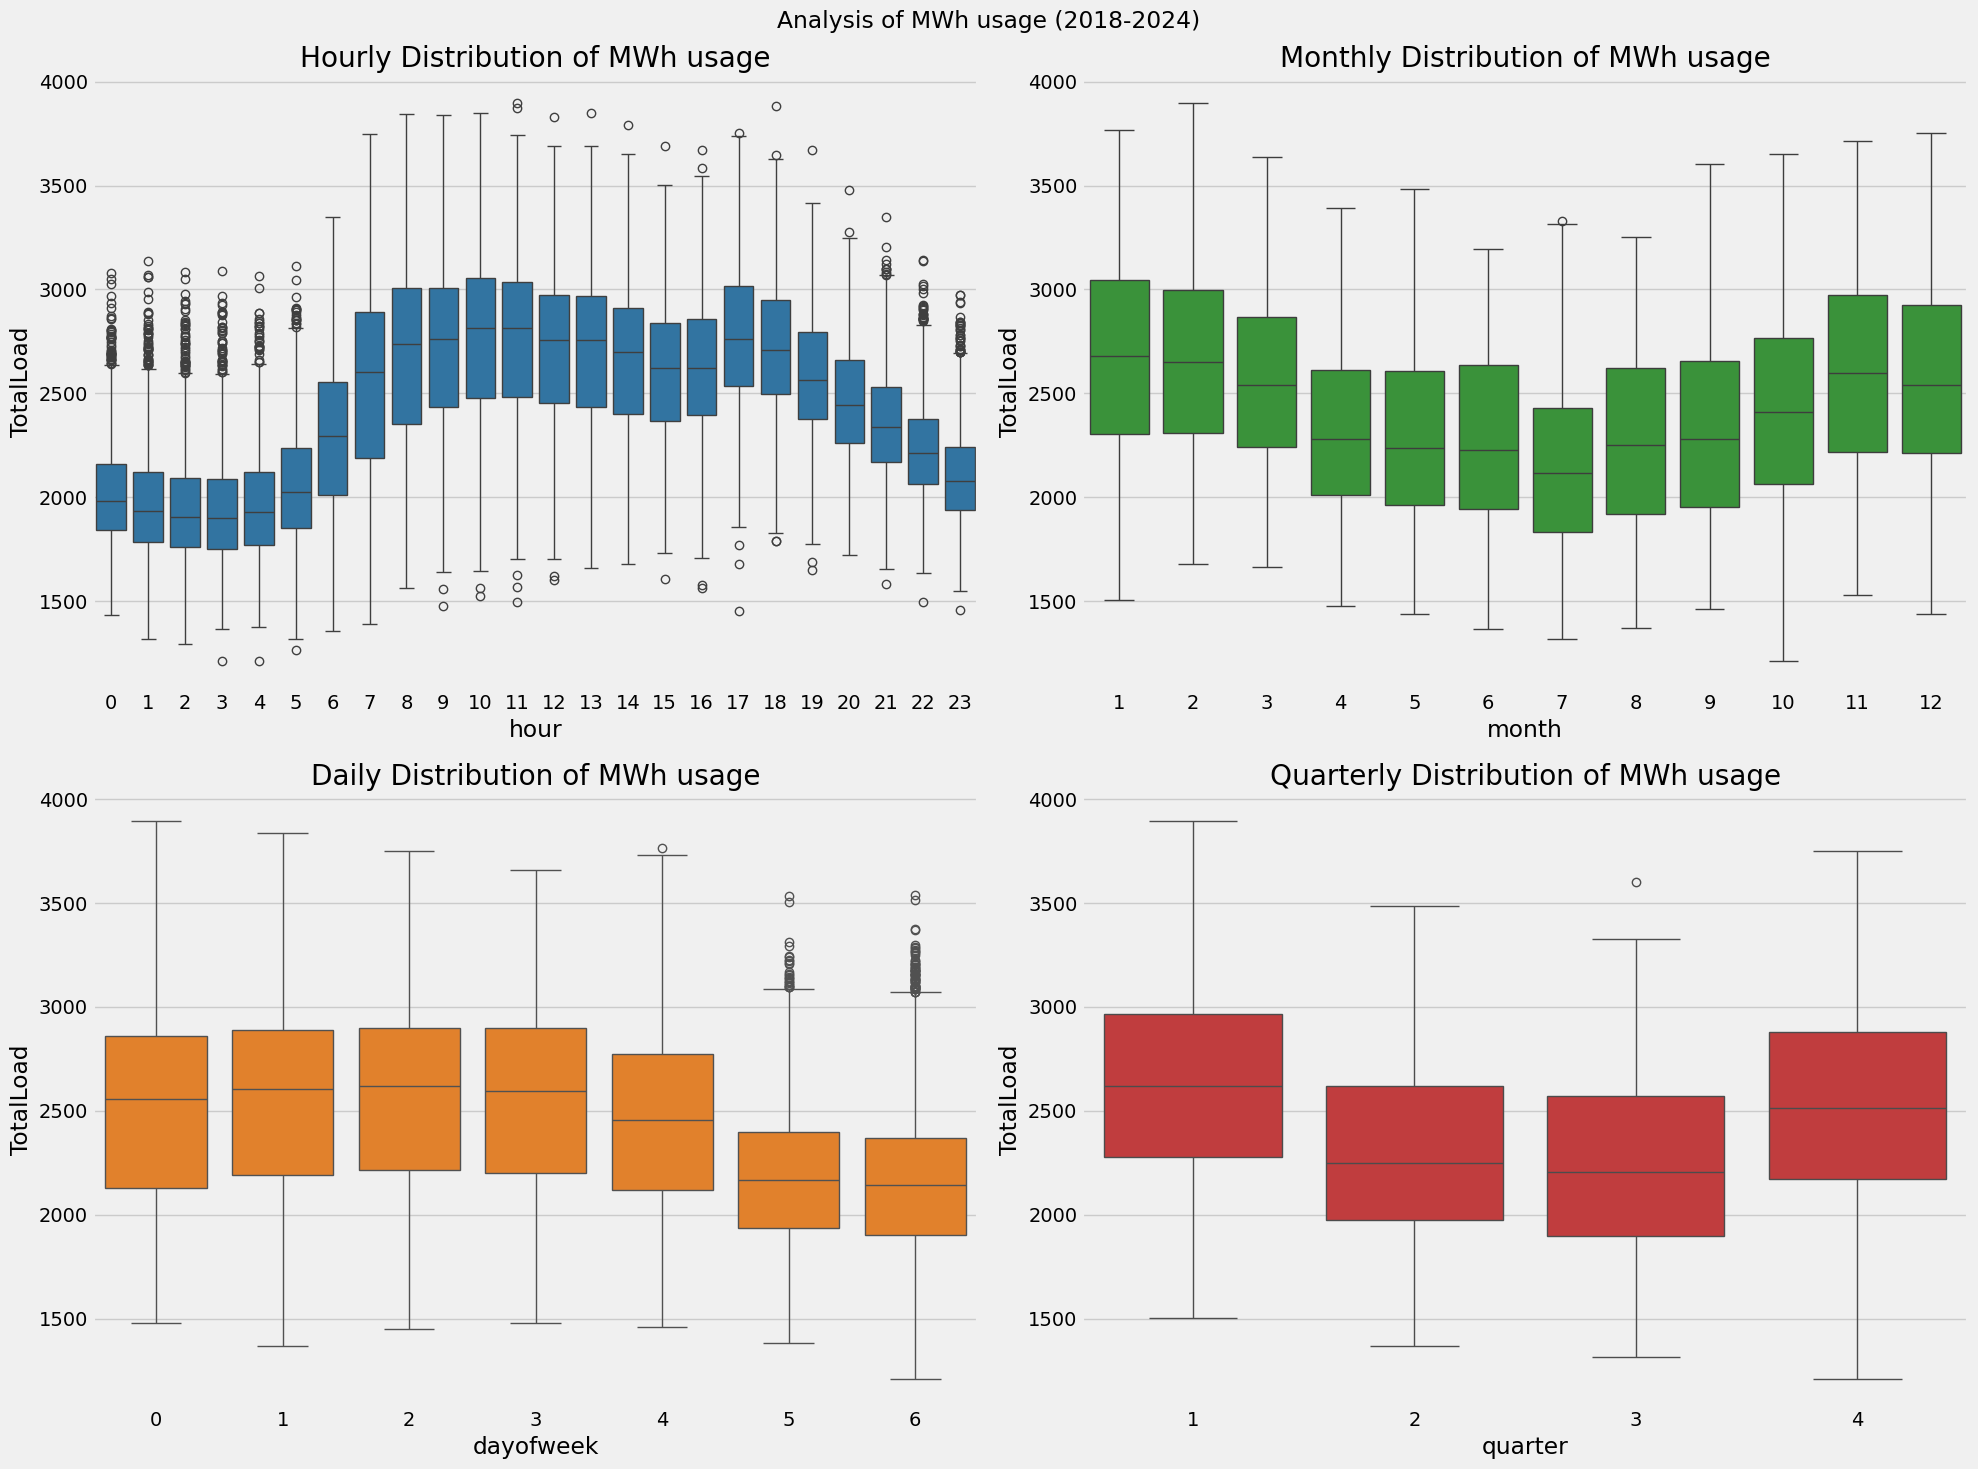

In [29]:
# Boxplots

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# Plot 1 – hourly
sns.boxplot(ax=axes[0,0], data=df_total, x='hour', y='TotalLoad', color=plot_colors[0])
axes[0,0].set_title('Hourly Distribution of MWh usage')

# Plot 2 – day of week
sns.boxplot(ax=axes[1,0], data=df_total, x='dayofweek', y='TotalLoad', color=plot_colors[1])
axes[1,0].set_title('Daily Distribution of MWh usage')

# Plot 3 – monthly
sns.boxplot(ax=axes[0,1], data=df_total, x='month', y='TotalLoad', color=plot_colors[2]) # 0 = monday in the plot
axes[0,1].set_title('Monthly Distribution of MWh usage')

# Plot 4 – quarterly
sns.boxplot(ax=axes[1,1], data=df_total, x='quarter', y='TotalLoad', color=plot_colors[3])
axes[1,1].set_title('Quarterly Distribution of MWh usage')


fig.suptitle('Analysis of MWh usage (2018-2024)')
plt.tight_layout()
plt.show()


# Modelling

In [ ]:
# Fra https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

param_grid = {
    'n_estimators': [800, 900, 1000, 1100],  # Number of trees
    'learning_rate': [0.008, 0.005, 0.002],  # Learning rate
    'max_depth': [5, 7, 10],  # Maximum depth of trees
    'gamma': [0.1, 0.08, 0.12]
}

reg = xgb.XGBRegressor(random_state = 42)

finder = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring="r2",
    cv=tss,  # change this to the splitter subject to test
    verbose=4,
    return_train_score=True
)

finder.fit(X_train, y_train)

best_params = finder.best_params_


Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV 1/4] END gamma=0.1, learning_rate=0.008, max_depth=5, n_estimators=800;, score=(train=0.961, test=0.928) total time=  12.1s
[CV 2/4] END gamma=0.1, learning_rate=0.008, max_depth=5, n_estimators=800;, score=(train=0.951, test=0.914) total time=   2.9s
[CV 3/4] END gamma=0.1, learning_rate=0.008, max_depth=5, n_estimators=800;, score=(train=0.951, test=0.892) total time=   3.4s
[CV 4/4] END gamma=0.1, learning_rate=0.008, max_depth=5, n_estimators=800;, score=(train=0.943, test=0.860) total time=   6.9s
[CV 1/4] END gamma=0.1, learning_rate=0.008, max_depth=5, n_estimators=900;, score=(train=0.964, test=0.929) total time=   2.5s
[CV 2/4] END gamma=0.1, learning_rate=0.008, max_depth=5, n_estimators=900;, score=(train=0.953, test=0.914) total time=   3.0s
[CV 3/4] END gamma=0.1, learning_rate=0.008, max_depth=5, n_estimators=900;, score=(train=0.953, test=0.892) total time=   6.6s
[CV 4/4] END gamma=0.1, learning_rate=0.0

In [ ]:
best_params

{'gamma': 0.1, 'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 900}

In [ ]:
# optimal model
model = xgb.XGBRegressor(learning_rate = 0.1,
                         max_depth = 7,
                         n_estimators = 900,
                         gamma = 0.005) # {'gamma': 0.1, 'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 900}

# train model
model.fit(X_train, y_train)

# test score
test['y_pred'] = model.predict(X_test)
score = r2_score(y_test['TotalLoad'], test['y_pred'], multioutput='uniform_average')
print("Test Loss: {0:.3f}".format(score))


Test Loss: 0.841


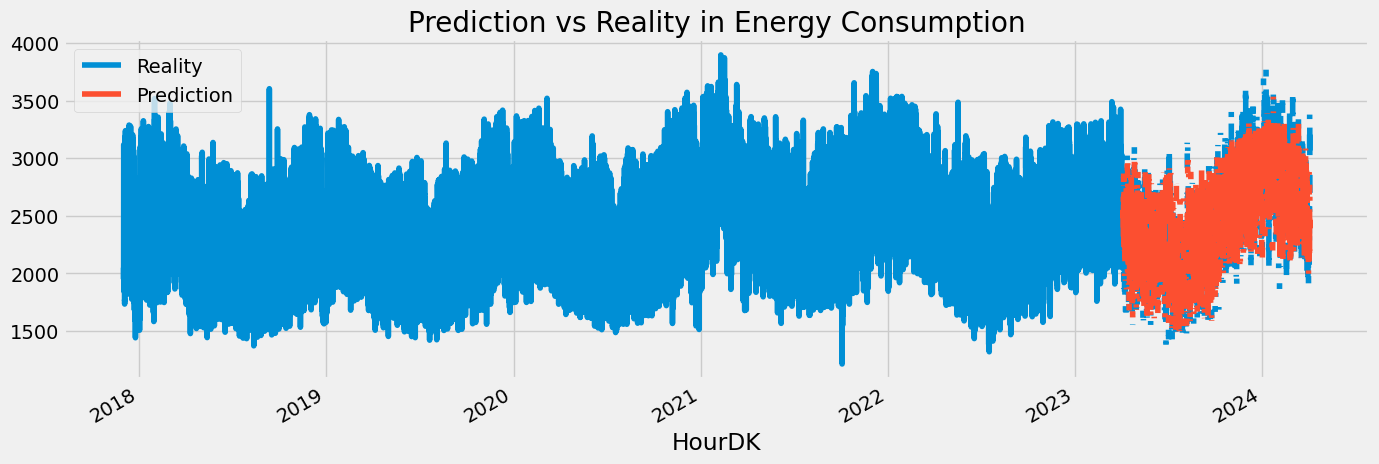

In [ ]:
# Visualizing the predictoions against reality
df_total_preds = pd.concat([df_total[['TotalLoad']], test[['y_pred']]])
df_total_preds[['TotalLoad', 'y_pred']].plot(figsize=(15,5), title='Prediction vs Reality in Energy Consumption')
plt.legend(['Reality', 'Prediction'])